# Prédiction conforme pour les données textuelles analysées par Transformers : application sur rapports médicaux

Benoliel Stuart
\
Carrere Charles
\
Thomas Louis

In [21]:
import sys
sys.version

# Importer les bibliothèques nécessaires
import torch
import random
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Seulement si besoin d'entrainer le Bert
%pip install signatory==1.2.6.1.9.0 --no-cache-dir --force-reinstall

In [ ]:
%pip install pandas transformers
%pip install scikit-learn
%pip install matplotlib
%pip install quantile-forest
%pip install seaborn

# Exploration des données

### Explore files in dataset

In [ ]:
import os

"""# Répertoire actuel
current_directory = os.getcwd()
print("Vous êtes dans le répertoire:", current_directory)

# Accéder au répertoire parent (A)
parent_directory = os.path.dirname(current_directory)

# Changer de répertoire de travail vers le répertoire parent
os.chdir(parent_directory)
# Vérifier le nouveau répertoire
new_directory = os.getcwd()
print("Vous êtes maintenant dans le répertoire:", new_directory)"""

pth = 'data/mimiciii'
files = [f for f in os.listdir(pth) if f.endswith('.csv.gz')]
print(f'Found {len(files)} files')
print('\n'.join(files))

### Explore data fields in dataset

In [ ]:
for f in files:
    for d in pd.read_csv(os.path.join(pth, f), low_memory=False, chunksize=200000):
        df = d
        break
    print(f"{f :=^80}")
    print('\n'.join(list(df.columns)))

### Explore data rows

In [ ]:
for f in files:
    for d in pd.read_csv(os.path.join(pth, f), low_memory=False, chunksize=200000):
        df = d
        break
    print(f"{f :=^80}")
    print(df.head(1))

# Importer les données + Stat descriptives
Dans cette section, nous chargeons les données à partir de fichiers CSV dans des DataFrames Pandas. Nous effectuons également des transformations sur les types de données et procédons au nettoyage des données en vue d'analyses futures.

In [ ]:
data = pd.concat([chunk for chunk in pd.read_csv(os.path.join(pth, 'NOTEEVENTS.csv.gz'), chunksize=20000)], axis=0)
len(data)
print(data.iloc[0,:])

In [ ]:
print(data.iloc[0,:]['TEXT'])

In [ ]:
# Convertir les colonnes 'SUBJECT_ID' et 'HADM_ID' en chaînes de caractères
data['SUBJECT_ID'] = data['SUBJECT_ID'].astype(str)
data['HADM_ID'] = data['HADM_ID'].astype(str)

# Le nettoyage de données. Remplacer la chaîne "nan" par des valeurs NaN réelles dans la colonne 'HADM_ID'
data['HADM_ID'] = data['HADM_ID'].replace("nan", np.nan)

# Convertir la colonne 'CHARTTIME' qui contient les timestamps en un format datetime avec le format spécifié
data['CHARTTIME'] = pd.to_datetime(data['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

# Supprimer les lignes ayant des valeurs manquantes dans la colonne 'HADM_ID'
data = data.dropna(subset=["HADM_ID"])

# Nettoyer le dataframe de champs nulles par supprimant les deux derniers caractères de la colonne 'HADM_ID'
data["HADM_ID"] = data["HADM_ID"].str[:-2]

# Convertir la colonne 'CHARTDATE' qui contient les timestamps en un format datetime
data['CHARTDATE'] = pd.to_datetime(data['CHARTDATE'])

# Convertir la colonne 'TIME' en entiers
# data['TIME'] = data['TIME'].astype(int)
data['TIME'] = 0

In [ ]:
adm = pd.concat([chunk for chunk in pd.read_csv(os.path.join(pth, 'ADMISSIONS.csv.gz'), chunksize=20000)], axis=0)
len(adm)
adm

In [ ]:
# Convertir les colonnes 'SUBJECT_ID' et 'HADM_ID' en chaînes de caractères
adm['SUBJECT_ID'] = adm['SUBJECT_ID'].astype(str)
adm['HADM_ID'] = adm['HADM_ID'].astype(str)

# Convertir la colonne 'HOSPITAL_EXPIRE_FLAG' en entiers
adm['HOSPITAL_EXPIRE_FLAG'] = adm['HOSPITAL_EXPIRE_FLAG'].astype(int)

# Convertir les colonnes 'ADMITIME' et 'DISCHTIME' en un format datetime avec le format spécifié
adm['ADMITTIME'] = pd.to_datetime(adm['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
adm['DISCHTIME'] = pd.to_datetime(adm['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
adm['DELTATIME'] = (adm['DISCHTIME'] - adm['ADMITTIME']).dt.total_seconds() / 3600

# Filtrer les données d'admission pour inclure uniquement les lignes avec des valeurs 'SUBJECT_ID' présentes dans le DataFrame 'data'
adm = adm.drop(adm[adm['DELTATIME'] < 0].index)
adm = adm[adm["SUBJECT_ID"].isin(data["SUBJECT_ID"].unique())]

In [ ]:
pat = pd.concat([chunk for chunk in pd.read_csv(os.path.join(pth, 'PATIENTS.csv.gz'), chunksize=20000)], axis=0)
len(pat)
pat
#alors ducoup ya pas assez de valeur non nulles pour l'age ca sert a rien

In [ ]:
df =  adm

df['DELTATIME'].describe()

In [ ]:
df.groupby('HOSPITAL_EXPIRE_FLAG')['DELTATIME'].describe()

In [ ]:
# Fonction pour calculer les quantiles
def quantile_plot(data, quantiles):
    q_values = data.quantile(quantiles)
    plt.plot(quantiles, q_values, marker='.', linestyle='-')

df =  adm
# Calcul des quantiles à afficher (par exemple, de 0 à 1 avec un pas de 0.01)
quantiles = np.arange(0.01, 1.01, 0.01)

plt.figure(figsize=(10, 6))

# Plot pour 'HOSPITAL_EXPIRE_FLAG' = 0
data_0 = df[df['HOSPITAL_EXPIRE_FLAG'] == 0]['DELTATIME']
quantile_plot(data_0, quantiles)
    
# Plot pour 'HOSPITAL_EXPIRE_FLAG' = 1
data_1 = df[df['HOSPITAL_EXPIRE_FLAG'] == 1]['DELTATIME']
quantile_plot(data_1, quantiles)

plt.xlabel('Quantiles')
plt.ylabel('DELTATIME')
plt.title('Graphique de Quantiles pour DELTATIME par HOSPITAL_EXPIRE_FLAG')
plt.legend(['Survivants (Flag=0)', 'Décédés (Flag=1)'])
plt.grid(True)
plt.show()

In [ ]:
df =  adm
plt.figure(figsize=(10, 6))

# Plot pour 'HOSPITAL_EXPIRE_FLAG' = 0
data_0 = df[df['HOSPITAL_EXPIRE_FLAG'] == 0]['DELTATIME']
quantile_plot(data_0, quantiles)
    
# Plot pour 'HOSPITAL_EXPIRE_FLAG' = 1
data_1 = df[df['HOSPITAL_EXPIRE_FLAG'] == 1]['DELTATIME']
quantile_plot(data_1, quantiles)

plt.xlabel('Quantiles')
plt.xlim(left = 0, right = 1)
plt.ylabel('DELTATIME')
plt.ylim(0, 1000)
plt.title('Graphique de Quantiles pour DELTATIME par HOSPITAL_EXPIRE_FLAG')
plt.legend(['Survivants (Flag=0)', 'Décédés (Flag=1)'])
plt.grid(True)
plt.show()

In [ ]:
df =  adm
# Réglage du style (optionnel)
sns.set(style='ticks')

# Création de l'histogramme empilé avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DELTATIME', hue='HOSPITAL_EXPIRE_FLAG', binwidth=50, kde=False, stat='density', common_norm=False, multiple='stack', element="bars", palette="deep")

plt.xlabel('DELTATIME')
plt.ylabel('Fréquence relative')
plt.title('Histogramme empilé de DELTATIME par HOSPITAL_EXPIRE_FLAG ')
plt.legend(['Décédés (Flag=1)', 'Survivants (Flag=0)'])
plt.show()

In [ ]:
df =  adm
# Réglage du style (optionnel)
sns.set(style='ticks')

# Création de l'histogramme empilé avec Seaborn
plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df, x='DELTATIME', hue='HOSPITAL_EXPIRE_FLAG', binwidth=10, kde=False, stat='density', common_norm=False, multiple='stack', element="bars", palette="deep")

plt.xlabel('DELTATIME')
plt.xlim(left = 0, right=1000)
plt.ylabel('Fréquence relative')
plt.title('Histogramme empilé de DELTATIME par HOSPITAL_EXPIRE_FLAG ')
plt.legend(['Décédés (Flag=1)', 'Survivants (Flag=0)'])
plt.show()

In [ ]:
df =  adm[adm['HOSPITAL_EXPIRE_FLAG']==1]
sns.set(style='ticks')
palette = sns.color_palette("deep")

# Création de l'histogramme empilé avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DELTATIME', hue='HOSPITAL_EXPIRE_FLAG', binwidth=10, kde=False, stat='density', common_norm=False, multiple='stack', element="bars", color = palette[1])

plt.xlabel('DELTATIME')
plt.xlim(left = 0, right=1000)
plt.ylabel('Fréquence relative')
plt.title('Histogramme de DELTATIME pour les décès')
plt.show()

In [ ]:
df =  adm[adm['HOSPITAL_EXPIRE_FLAG']==0]
sns.set(style='ticks')

# Création de l'histogramme empilé avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DELTATIME', hue='HOSPITAL_EXPIRE_FLAG', binwidth=10, kde=False, stat='density', common_norm=False, multiple='stack', element="bars", palette="deep")

plt.xlabel('DELTATIME')
plt.xlim(left = 0, right=1000)
plt.ylabel('Fréquence relative')
plt.title('Histogramme de DELTATIME pour les survivants')
plt.show()

In [ ]:
df =  adm[adm['HOSPITAL_EXPIRE_FLAG']==0]
sns.set(style='ticks')

# Création de l'histogramme empilé avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DELTATIME', hue='HOSPITAL_EXPIRE_FLAG', binwidth=1, kde=False, stat='density', common_norm=False, multiple='stack', element="bars", palette="deep")

plt.xlabel('DELTATIME')
plt.xlim(left = 20, right=60)
plt.ylabel('Fréquence relative')
plt.title('Histogramme de DELTATIME pour les survivants')
plt.show()

# Créer les jeux de test et d'entraînement
Cette section concerne la création des ensembles de données utilisés pour l'apprentissage et les tests. Nous regroupons les données relatives aux patients selon leurs identifiants uniques, puis nous les étiquetons en fonction de la présence ou non d'une condition spécifique. Cette étape permet ainsi la formation de l'ensemble d'apprentissage. De plus, nous sélectionnons aléatoirement un sous-ensemble de patients pour constituer l'ensemble de test.

Le but de cet étape est la division le jeu de données pour laisser entrainer le modèle et ainsi le évaluer. La division raisonnable est crucial pour obtenir un vrai metrique de modèle et aussi éviter "overfitting" ou "underfitting".

Puis, le modèle s'entrainera sur le jeu d'entrainement et après on calcule la metrique sur le jeu de test. Ce metrique montre comment notre modèle marche sur les données reéls et ainsi on peut comparer les modèles differentes.

In [ ]:
# Créer un dataframe vide avec deux colonnes pour le nouveau dataframe
new_data = pd.DataFrame(columns=["SUBJECT_ID", "HOSPITAL_EXPIRE_FLAG"])

# Grouper les données d'admission par "SUBJECT_ID"
grouped_adm = adm.groupby("SUBJECT_ID")
print(len(grouped_adm))

# Parcourir chaque groupe de données associées à un "SUBJECT_ID"
for subject_id, group in grouped_adm:
    # Vérifier si le groupe contient au moins un enregistrement avec la valeur 1 dans la colonne "HOSPITAL_EXPIRE_FLAG"
    if group["HOSPITAL_EXPIRE_FLAG"].eq(1).any():
        # Si oui, ajouter le "SUBJECT_ID" et la valeur 1 dans le nouveau dataframe
        new_data = pd.concat([new_data, pd.DataFrame({"SUBJECT_ID": [subject_id], "HOSPITAL_EXPIRE_FLAG": [1]})], ignore_index=True)
    else:
        # Sinon, ajouter le "SUBJECT_ID" et la valeur 0 dans le nouveau dataframe
        new_data = pd.concat([new_data, pd.DataFrame({"SUBJECT_ID": [subject_id], "HOSPITAL_EXPIRE_FLAG": [0]})], ignore_index=True)

## Fonction pour diviser les documents en plus petits morceaux
Dans cette partie, nous définissons une fonction permettant de découper les documents textuels en segments plus petits afin de faciliter leur traitement ultérieur.

In [ ]:
def split_text(text, k):
    # Convertir le texte en une liste de mots
    words = text.split()

    # Déterminer le nombre total de mots dans le texte
    num_words = len(words)

    # Calculer le nombre de mots par partie
    words_per_part = num_words // k

    # Calculer le nombre de mots restants si num_words n'est pas un multiple de k
    remainder = num_words % k

    # Initialiser une liste pour stocker les parties découpées du texte
    parts = []

    # Initialiser l'indice de début pour la découpe
    start = 0

    # Parcourir chaque partie
    for i in range(k):
        # Calculer la position de fin pour la i-ème partie
        end = start + words_per_part + (i < remainder)
        # La variable "end" correspond à la position du dernier mot de la i-ème partie

        # Ajouter la partie actuelle à la liste des parties
        parts.append(words[start:end])

        # Mettre à jour l'indice de début pour la prochaine partie
        start = end

    # Convertir les listes de mots en chaînes de caractères
    parts = [" ".join(part) for part in parts]

    return parts

## Charger le modèle ClinicalBERT depuis Hugging Face
Dans cette partie, nous chargeons le modèle ClinicalBERT ainsi que son tokenizer depuis la bibliothèque Hugging Face. Ces éléments sont indispensables pour extraire les représentations vectorielles à partir des informations textuelles des patients.

In [ ]:
# Importer les bibliothèques nécessaires
from transformers import AutoTokenizer, AutoModel
from torch import nn

# Charger le modèle de langue pré-entraîné (Bio_ClinicalBERT) et le tokenizer associé
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to("cuda")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

device = torch.device('cuda')
torch.cuda.set_device(0)
print('Using device:', device)
print()

### [TRAIN]

In [ ]:
# Créer un nouveau dataframe avec les "SUBJECT_ID" ayant la valeur 1 dans la colonne "HOSPITAL_EXPIRE_FLAG"
label_1 = new_data[new_data["HOSPITAL_EXPIRE_FLAG"] == 1].reset_index()

# Sélectionner aléatoirement le même nombre de "SUBJECT_ID" ayant la valeur 0 ???
label_0 = new_data[new_data["HOSPITAL_EXPIRE_FLAG"] == 0].reset_index()

# Sélectionner aléatoirement 1000 individus de chaque classe (label_1 et label_0)
sample = pd.concat([label_1.sample(n=1000, random_state=seed), label_0.sample(n=1000, random_state=seed+1)]).reset_index().drop('index', axis=1)

# Filtrer le dataframe de données en ne conservant que les patients sélectionnés précédemment
filtered_data = data[data["SUBJECT_ID"].isin(sample["SUBJECT_ID"].values)]

# Regrouper les données filtrées par 'SUBJECT_ID' en agrégeant les listes de 'TEXT' et 'TIME'
grouped_sample = filtered_data.groupby('SUBJECT_ID').agg({'TEXT': list, 'TIME': list}).reset_index()

### [TEST]

In [ ]:
# Filtrer les données test (new_data) pour ne conserver que les patients absents
new_data_test = new_data[~new_data["SUBJECT_ID"].isin(sample["SUBJECT_ID"].values)]

# Sélectionner les données test ayant la valeur "HOSPITAL_EXPIRE_FLAG" égale à 1 (décédés)
label_1 = new_data_test[new_data_test["HOSPITAL_EXPIRE_FLAG"] == 1].reset_index()

# Sélectionner aléatoirement le même nombre de "SUBJECT_ID" ayant la valeur "HOSPITAL_EXPIRE_FLAG" égale à 0 (non décédés)
label_0 = new_data_test[new_data_test["HOSPITAL_EXPIRE_FLAG"] == 0].reset_index()

# Créer un échantillon test en combinant les données décédées (150 patients) et non décédées (850 patients)
sample_test = pd.concat([label_1.sample(n=150, random_state=seed), label_0.sample(n=850, random_state=seed+1)]).reset_index().drop('index', axis=1)

# Filtrer les données d'observation (data) pour ne conserver que les patients présents dans l'échantillon test (sample_test)
filtered_data_test = data[data["SUBJECT_ID"].isin(sample_test["SUBJECT_ID"].values)]

# Regrouper les données test par "SUBJECT_ID" en listes de textes et de temps
grouped_sample_test = filtered_data_test.groupby('SUBJECT_ID').agg({'TEXT': list, 'TIME': list}).reset_index()

## Extraire les tokens CLS
Dans cette partie, le code se focalise sur l'extraction des embeddings ClinicalBERT. Les embeddings sont extraits en découpant le texte en parts et en calculant les représentations pour chaque part. Le résultat est un dictionnaire qui associe chaque patient à ses embeddings ClinicalBERT.


In [ ]:
def extract_token(grouped_sample):
    # Créer un dictionnaire de la forme {n° patient: [liste des textes, valeurs time]} pour faciliter l'itération
    grouped_texts_dict = grouped_sample.set_index('SUBJECT_ID')[['TEXT', 'TIME']].to_dict(orient='index')

    # Initialiser une liste pour stocker les valeurs 'TIME' de chaque partie d'un document
    time_list = []

    # Initialiser un dictionnaire pour stocker les embeddings
    embeddings_dict = {}

    # Parcourir les patients et leurs données associées
    for subject_id, values in grouped_texts_dict.items():
        texts = values['TEXT']  # Récupérer la liste des documents
        times = values['TIME']  # Récupérer la liste des valeurs 'TIME' associées aux documents
        embeddings_list = []  # Liste pour stocker les embeddings de toutes les parties de tous les documents

        # Parcourir les documents et leurs valeurs 'TIME' associées
        for text, time in zip(texts, times):
            # Diviser le texte en parties égales
            encoded_text = tokenizer.encode(text)  # Encodage du texte en une séquence de tokens
            n_tokens = len(encoded_text)  # Nombre de tokens dans la séquence
            n_chunks = max(1, n_tokens // 512)  # Calcul du nombre optimal de parties
            parties = split_text(text, n_chunks)  # Liste des parties du texte

            # Stocker les embeddings des différentes parties du document
            cls_embeddings_list = []  # Liste pour stocker les embeddings [CLS] des parties

            # Parcourir les parties du document
            for partie in parties:
                # Convertir la partie dans un format compatible avec le modèle
                inputs = tokenizer(partie, return_tensors='pt', padding=True, truncation=True, max_length=512).to("cuda")

                with torch.no_grad():
                    # Effectuer l'inférence pour obtenir les résultats du modèle
                    outputs = model(**inputs)

                # Récupérer l'embedding du token [CLS] pour chaque partie
                cls_embeddings = outputs.last_hidden_state[:, 0, :]
                # Stocker l'embedding dans la liste
                cls_embeddings_list.append(cls_embeddings)
                # Stocker la valeur 'TIME' (la même pour toutes les parties du même document)
                time_list.append(time)

            # Ajouter la liste des embeddings [CLS] à la liste des embeddings de ce document
            embeddings_list += cls_embeddings_list

        # Stocker les embeddings dans un dictionnaire avec le numéro du patient comme clé
        embeddings_dict[subject_id] = torch.stack(embeddings_list)
    return embeddings_dict , time_list


### [TRAIN]

In [ ]:
embeddings_dict, time_list = extract_token(grouped_sample)

### [TEST]

In [ ]:
embeddings_dict_test, time_list_test = extract_token(grouped_sample_set)

## Réduction de dimension
Ici, le code se concentre sur la réduction de la dimensionnalité des embeddings obtenus lors de l'étape précédente. Il utilise une technique appelée projection gaussienne aléatoire pour transformer les embeddings dans un espace de dimension inférieure, ce qui rend les données plus gérables et peut potentiellement améliorer les performances du modèle. Le résultat est un dictionnaire contenant les embeddings réduits pour chaque patient.

Le but de cette action c'est de faire plus simple le modele donc il demande moins de ressources pour entrainer.

### Projection gaussienne aléatoire
Cette partie du code a pour objectif de réduire la dimensionnalité des embeddings extraits lors de l'étape précédente en utilisant une projection gaussienne aléatoire. Le résultat est un ensemble d'embeddings de plus petite dimension qui peut faciliter l'analyse ultérieure.

In [ ]:
# Importer la classe random_projection du module sklearn
from sklearn import random_projection

def project_gaussian(embeddings_dict, time_list):

    # ClinicalBERT renvoie des embeddings au format de tensor PyTorch.
    # Nous les convertissons en tableau NumPy pour la réduction de dimension
    flattened_embeddings_dict = {key: tensor.view(tensor.shape[0], -1).cpu().numpy() for key, tensor in embeddings_dict.items()}

    # Créer une liste pour stocker le nombre d'embeddings que possède chaque patient
    lengths = [len(tensor) for tensor in flattened_embeddings_dict.values()]

    # Concaténer tous les embeddings pour créer une matrice unique
    embeddings_np = np.concatenate(list(flattened_embeddings_dict.values()))

    # Initialiser la projection gaussienne aléatoire avec 100 composantes
    transformer = random_projection.GaussianRandomProjection(n_components=100)

    # Réduire la dimension des embeddings en utilisant la projection gaussienne aléatoire
    reduced_embeddings_np = transformer.fit_transform(embeddings_np)

    # Diviser les embeddings réduits pour chaque patient
    reduced_embeddings_list = np.split(reduced_embeddings_np, np.cumsum(lengths)[:-1])

    # Recréer le dictionnaire des embeddings réduits avec les numéros de patient correspondants
    reduced_embeddings_dict = {key: tensor for key, tensor in zip(flattened_embeddings_dict.keys(), reduced_embeddings_list)}

    # Filtrer les embeddings dont la forme est différente de (1, 100)
    filtered_embeddings_dict = {key: value for key, value in reduced_embeddings_dict.items() if value.shape != (1, 100)}
    reduced_embeddings_dict = filtered_embeddings_dict
    del filtered_embeddings_dict  # Supprimer la variable temporaire

    # Ajouter la valeur 'time' à la fin de chaque embedding
    for key, time in zip(reduced_embeddings_dict.keys(), time_list):
        array_vide = np.empty((reduced_embeddings_dict[key].shape[0], 101))
        for i in range(reduced_embeddings_dict[key].shape[0]):
            array = np.append(reduced_embeddings_dict[key][i], time)
            array_vide[i:] = array
        reduced_embeddings_dict[key] = array_vide
    return reduced_embeddings_dict

#### [TRAIN] 

In [ ]:
reduced_embeddings_dict = project_gaussian(embeddings_dict, time_list)

# Vérifier que le lien entre chaque sujet et ses embeddings est conservé
for key in reduced_embeddings_dict.keys():
    print(f"Subject ID: {key}, Embedding shape: {reduced_embeddings_dict[key].shape}")
    break

#### [TEST] 

In [ ]:
reduced_embeddings_dict_test = project_gaussian(embeddings_dict_test, time_list_test)

# Vérifier que le lien entre chaque sujet et ses embeddings est conservé
for key in reduced_embeddings_dict_test.keys():
    print(f"Subject ID: {key}, Embedding shape: {reduced_embeddings_dict_test[key].shape}")
    break

### ACP
Dans cette section, nous appliquons une Analyse en Composantes Principales (ACP) aux embeddings. L'objectif de l'ACP est de réduire davantage la dimensionnalité des données tout en préservant autant d'informations que possible. Le code calcule la variance expliquée par chaque composante principale, ce qui permet d'évaluer l'efficacité de la réduction de dimension.

In [ ]:
# Importer la classe PCA (Analyse en Composantes Principales) du module sklearn
from sklearn.decomposition import PCA

def ACP(embeddings_dict, time_list):
    # Créer un nouveau dictionnaire pour stocker les embeddings aplatis
    flattened_embeddings_dict = {key: tensor.view(tensor.shape[0], -1).cpu().numpy() for key, tensor in embeddings_dict.items()}

    # Créer une liste pour stocker le nombre d'embeddings pour chaque patient
    lengths = [len(tensor) for tensor in flattened_embeddings_dict.values()]

    # Concaténer tous les embeddings en une seule matrice
    embeddings_np = np.concatenate(list(flattened_embeddings_dict.values()))

    # Initialiser le modèle PCA (Analyse en Composantes Principales) avec 100 composantes
    pca = PCA(n_components=100)

    # Ajuster le modèle PCA aux données et les transformer pour réduire la dimension
    reduced_embeddings_np = pca.fit_transform(embeddings_np)

    # Séparer les embeddings transformés pour chaque sujet
    reduced_embeddings_list = np.split(reduced_embeddings_np, np.cumsum(lengths)[:-1])

    # Recréer le dictionnaire des embeddings transformés avec les clés correspondantes
    reduced_embeddings_dict = {key: tensor for key, tensor in zip(flattened_embeddings_dict.keys(), reduced_embeddings_list)}

    # Filtrer les embeddings dont la forme est différente de (1, 100)
    filtered_embeddings_dict = {key: value for key, value in reduced_embeddings_dict.items() if value.shape != (1, 100)}
    reduced_embeddings_dict = filtered_embeddings_dict
    del filtered_embeddings_dict  # Supprimer la variable temporaire

    # Ajouter la valeur 'time' à la fin de chaque embedding
    for key, time in zip(reduced_embeddings_dict.keys(), time_list):
        # Créer un tableau vide pour stocker les embeddings avec le temps
        array_vide = np.empty((reduced_embeddings_dict[key].shape[0], 101))
        for i in range(reduced_embeddings_dict[key].shape[0]):
            # Ajouter la valeur 'time' à la fin de chaque embedding
            array = np.append(reduced_embeddings_dict[key][i], time)
            array_vide[i:] = array
        reduced_embeddings_dict[key] = array_vide
    # Afficher la variance expliquée par chaque composante principale
    print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)

    # Afficher la variance totale expliquée par toutes les composantes principales
    print("Variance totale expliquée:", sum(pca.explained_variance_ratio_))
    return reduced_embeddings_dict


#### [TRAIN] 

In [ ]:
reduced_embeddings_dict = ACP(embeddings_dict, time_list)

# Vérifier que le lien entre chaque sujet et ses embeddings est bien conservé
for key in reduced_embeddings_dict.keys():
    print(f"ID du patient : {key}, Forme des embeddings : {reduced_embeddings_dict[key].shape}")
    break

#### [TEST] 

In [ ]:
reduced_embeddings_dict_test = ACP(embeddings_dict_test, time_list_test)

# Vérifier que le lien entre chaque sujet et ses embeddings est bien conservé
for key in reduced_embeddings_dict_test.keys():
    print(f"Subject ID: {key}, Embedding shape: {reduced_embeddings_dict_test[key].shape}")
    break


## Calculer les signatures
Cette partie du code calcule les signatures logarithmiques pour les embeddings réduits.
Les signatures logarithmiques capturent des informations plus complexes dans les données, ce qui peut être très utile lors de l'entraînement d'un modèle de prédiction. Cela aboutit à la création d'un dictionnaire où chaque patient est représenté par des plongements sous forme de signatures logarithmiques.

In [ ]:
# Importer les bibliothèques nécessaires
import signatory

def log_signa(reduced_embeddings_dict):

    # Ordre de la signature tronquée
    depth = 2

    # Créer un nouveau dictionnaire pour stocker les résultats de la log signature
    log_signature_dict = {}

    # Parcourir le dictionnaire des embeddings réduits (reduced_embeddings_dict)
    for key, value in reduced_embeddings_dict.items():
        # Convertir les tableaux NumPy en tenseurs PyTorch de type float
        tensor = torch.from_numpy(value).float().to("cuda")

        # Ajouter une dimension "batch" pour correspondre au format requis (batch, stream, channel)
        tensor = tensor.unsqueeze(0).to("cuda")

        # Calculer la log signature en utilisant la bibliothèque Signatory
        log_signature = signatory.logsignature(path=tensor, depth=depth)

        # Enlever la dimension "batch" que nous avons ajoutée précédemment
        log_signature = log_signature.squeeze(0).to("cuda")

        # Ajouter le résultat dans le dictionnaire log_signature_dict
        log_signature_dict[key] = log_signature
    return log_signature_dict

### [TRAIN] 

In [ ]:
log_signature_dict = log_signa(reduced_embeddings_dict)
# À ce stade, log_signature_dict est un dictionnaire où chaque clé correspond à un numéro de patient, et chaque valeur est la log signature de ce patient.
print(log_signature_dict)

### [TEST] 

In [ ]:
log_signature_dict_test = log_signa(reduced_embeddings_dict_test)

## [TRAIN] Dataframe utilisé pour l'entraînement
Après avoir effectué l'extraction, la réduction de dimension et le calcul des signatures logarithmiques pour les embeddings, le code transforme les résultats en un DataFrame Pandas.

In [ ]:
# Convertir le dictionnaire log_signature_dict en un DataFrame
df_features = pd.DataFrame.from_dict(log_signature_dict, orient='index')

# Réinitialiser l'index pour que 'SUBJECT_ID' devienne une colonne du DataFrame
df_features.reset_index(inplace=True)

# Renommer la colonne d'index en 'SUBJECT_ID'
df_features.rename(columns={'index':'SUBJECT_ID'}, inplace=True)

# Parcourir chaque colonne du DataFrame et convertir chaque tenseur en float (si nécessaire)
for col in df_features.columns:
    df_features[col] = df_features[col].apply(lambda x: x.item() if torch.is_tensor(x) else x)

# Fusionner le DataFrame df_features avec le DataFrame new_data sur la colonne 'SUBJECT_ID'
df_final = pd.merge(df_features, new_data[['SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']], on='SUBJECT_ID', how='inner')

# Afficher la forme (nombre de lignes et de colonnes) du DataFrame df_final
df_final.shape

df_final.head()

## [TEST] Dataframe utilisé pour le test
Enfin, cette partie transforme les résultats de l'analyse en un DataFrame Pandas prêt à être utilisé pour évaluer comment le modèle se comporte sur le jeu de données de test. Ce DataFrame comprend également les étiquettes des patients, ce qui facilite l'évaluation des performances du modèle.

In [ ]:
# Convertir le dictionnaire en un DataFrame
df_features_test = pd.DataFrame.from_dict(log_signature_dict_test, orient='index')

# Réinitialiser l'index du DataFrame pour que SUBJECT_ID devienne une colonne
df_features_test.reset_index(inplace=True)

# Renommer la colonne 'index' en 'SUBJECT_ID' pour avoir une colonne de sujet
df_features_test.rename(columns={'index':'SUBJECT_ID'}, inplace=True)

# Parcourir chaque colonne du DataFrame et convertir chaque tenseur en float si nécessaire
for col in df_features_test.columns:
    df_features_test[col] = df_features_test[col].apply(lambda x: x.item() if torch.is_tensor(x) else x)

# Fusionner le DataFrame df_features_test avec le DataFrame new_data_test sur la colonne SUBJECT_ID en utilisant une jointure interne
df_final_test = pd.merge(df_features_test, new_data_test[['SUBJECT_ID', 'HOSPITAL_EXPIRE_FLAG']], on='SUBJECT_ID', how='inner')

# Afficher le nombre de colonnes du DataFrame final (nombre de caractéristiques + 1 pour la colonne 'HOSPITAL_EXPIRE_FLAG')

df_final_test.shape[1]

## Enregistrement données traités

In [ ]:
with open('data/traite/data_train', 'wb') as f1:
    pickle.dump(df_final, f1)
with open('data/traite/data_test', 'wb') as f1:
    pickle.dump(df_final_test, f1)

# Importation données pré-traités

In [2]:
with open('data/traite/data_train', 'rb') as f1:
    df_final = pickle.load(f1)
with open('data/traite/data_test', 'rb') as f1:
    df_final_test = pickle.load(f1)

print("Dataset: %s" % (df_final.shape,))
print("Dataset de test (+ calibration): %s" % (df_final_test.shape,))

Dataset: (1999, 5153)
Dataset de test (+ calibration): (998, 5153)


In [ ]:
with open('data/traite/pred_cqr', 'rb') as f1:
    pred_cqr = pickle.load(f1)
with open('data/traite/pred_rf', 'rb') as f1:
    pred_rf = pickle.load(f1)
with open('data/traite/y_lower_cqr', 'rb') as f1:
    y_lower_cqr = pickle.load(f1)
with open('data/traite/y_upper_cqr', 'rb') as f1:
    y_upper_cqr = pickle.load(f1)
with open('data/traite/y_lower_cvp', 'rb') as f1:
    y_lower_cvp = pickle.load(f1)
with open('data/traite/y_upper_cvp', 'rb') as f1:
    y_upper_cvp = pickle.load(f1)
with open('data/traite/y_lower_split', 'rb') as f1:
    y_lower_split = pickle.load(f1)
with open('data/traite/y_upper_split', 'rb') as f1:
    y_upper_split = pickle.load(f1)

In [3]:
def plot_func(y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False,
              max_show=100):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    y_ = y[:max_show]
    x_ = np.arange(1, len(y_) + 1)

    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    plt.plot(x_, y_, 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_, x_[::-1]]),
                 np.concatenate([y_u_, y_l_[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_, pred_[:,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_, pred_[:,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_, pred_, 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def plot_hist(length,
              in_the_range,
              x_name="",
              dec_x_quant=[0,0,0],
              draw_quant=True,
              filename=None,
              save_figures=False):

    df = pd.DataFrame({
        'length': length,
        'in_the_range': in_the_range
    })

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(data=df, x='length', hue='in_the_range', multiple="stack", stat='percent',
        palette={True: 'green', False: 'red'}, bins=20, hue_order=[True, False])
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=2, title="Vrai valeur dans l'intervalle de prédiction:", frameon=False,
    )

    if draw_quant:
        # Calcul des quantiles
        quantiles = [np.percentile(length, i) for i in range(25, 100, 25)]

        # Calcul de la hauteur maximale pour les barres verticales
        ymax = plt.ylim()[1] 

        # Tracé des lignes verticales pour les quantiles et ajout des étiquettes
        for i, quantile in enumerate(quantiles, 1):
            plt.vlines(x=quantile, ymin=0, ymax=ymax*9/10 , linestyle='--', linewidth=1.5, color='black')
            plt.text(quantile+dec_x_quant[i-1], ymax*9/10, f'Q{i}:\n{round(quantile)}', va='bottom', ha='center', color='black', fontsize=9, rotation=0)

    plt.xlabel(x_name)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

## Ajout variables + Changement var d'intérêt si souhaité

In [4]:
import os
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

Regression = False # Choix d'aller sur regression ou rester sur binaire

adm = pd.concat([chunk for chunk in pd.read_csv(os.path.join('data/mimiciii', 'ADMISSIONS.csv.gz'), chunksize=20000)], axis=0)
pat = pd.concat([chunk for chunk in pd.read_csv(os.path.join('data/mimiciii', 'PATIENTS.csv.gz'), chunksize=20000)], axis=0)

# Convertir les colonnes 'SUBJECT_ID' en chaînes de caractères
adm['SUBJECT_ID'] = adm['SUBJECT_ID'].astype(str)
pat['SUBJECT_ID'] = pat['SUBJECT_ID'].astype(str)

# Séparation des données en ensembles d'entraînement et de test
X_train = df_final.iloc[:, 0:-1]
X_train = pd.merge(X_train, adm, on='SUBJECT_ID', how='left')
X_train = pd.merge(X_train, pat, on='SUBJECT_ID', how='left')
X_train['ADMITTIME'] = pd.to_datetime(X_train['ADMITTIME'])
X_train['DISCHTIME'] = pd.to_datetime(X_train['DISCHTIME'])
X_train['DELTATIME'] = (X_train['DISCHTIME'] - X_train['ADMITTIME']).dt.total_seconds() / 3600
X_train = X_train.drop(X_train[X_train['DELTATIME'] < 0].index)
X_train = X_train.sort_values(by='ADMITTIME', ascending=False)

# Extraction des noms de colonnes des variables numériques
numerical_columns = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Conversion des variables catégorielles en valeurs encodées
x_categorical = X_train.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# Création du DataFrame des variables numériques avec les noms de colonnes
x_numerical = X_train[numerical_columns]

# Concaténation des variables numériques et catégorielles
X_train = pd.concat([x_numerical, x_categorical], axis=1)

# Supprimez les doublons conservés dans 'X_train' en conservant uniquement la première occurrence (la plus tardive)
X_train = X_train.drop_duplicates(subset='SUBJECT_ID', keep='first')

if Regression :
    y_train = X_train['DELTATIME']
else :
    y_train = X_train["HOSPITAL_EXPIRE_FLAG"].astype(int)

X_train = X_train.iloc[:, list(range(1, 5151)) ] # + [5162, 5165, 5166, 5173] 
X_train.columns = X_train.columns.astype(str)

X_test = df_final_test.iloc[:, 0:-1]
X_test = pd.merge(X_test, adm, on='SUBJECT_ID', how='left')
X_test = pd.merge(X_test, pat, on='SUBJECT_ID', how='left')
X_test['ADMITTIME'] = pd.to_datetime(X_test['ADMITTIME'])
X_test['DISCHTIME'] = pd.to_datetime(X_test['DISCHTIME'])
X_test['DELTATIME'] = (X_test['DISCHTIME'] - X_test['ADMITTIME']).dt.total_seconds() / 3600
X_test = X_test.drop(X_test[X_test['DELTATIME'] < 0].index)
X_test = X_test.sort_values(by='ADMITTIME', ascending=False)

# Extraction des noms de colonnes des variables numériques
numerical_columns = X_test.select_dtypes(exclude=['object']).columns.tolist()

# Conversion des variables catégorielles en valeurs encodées
x_categorical = X_test.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# Création du DataFrame des variables numériques avec les noms de colonnes
x_numerical = X_test[numerical_columns]

# Concaténation des variables numériques et catégorielles
X_test = pd.concat([x_numerical, x_categorical], axis=1)

# Supprimez les doublons conservés dans 'X_test' en conservant uniquement la première occurrence (la plus tardive)
X_test = X_test.drop_duplicates(subset='SUBJECT_ID', keep='first')

if Regression :
    y_test = X_test['DELTATIME']
else :
    y_test = X_test["HOSPITAL_EXPIRE_FLAG"].astype(int)
X_test = X_test.iloc[:, list(range(1, 5151)) ] # + [5162, 5165, 5166, 5173] <=> 'ADMISSION_TYPE', 'INSURANCE', 'LANGUAGE', 'GENDER'
X_test.columns = X_test.columns.astype(str)

print("Dataset: %s" % (X_train.shape,))
print("Dataset de test (+ calibration): %s" % (X_test.shape,))

# Problem setup
n = 500 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

# Split the data into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (X_test.shape[0]-n)) > 0
np.random.shuffle(idx)

# x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=seed)
# divide the data into proper training set and calibration set
# idx = np.random.permutation(n_train)
# n_half = int(np.floor(n_train/2))
# idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

Dataset: (1992, 5150)
Dataset de test (+ calibration): (997, 5150)


# Modèles ML Survie des patients (binaire)

## Reg Logistique

Dans cette partie, nous utilisons la classification par régression logistique pour analyser les données qui ont été préparées à partir des ensembles d'entraînement et de test. Le code commence par configurer un modèle de régression, puis le forme en utilisant les données d'entraînement et effectue des prédictions sur les données de test. Ensuite, il affiche la précision, le rappel et le score F1 du modèle. Cette section nous permet d'évaluer à quel point le modèle de régression logistique prédit avec précision la mortalité à l'hôpital en se basant sur les représentations réduites des données.

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Initialisation du modèle de régression logistique

# Créer une instance du modèle de régression logistique avec les hyperparamètres spécifiés et tuning du paramètres Cs
# inverse of regularization strength -> smaller values specify stronger regularization
model = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=1000, class_weight = 'balanced', random_state = seed, cv=5)

# Entraînement du modèle

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test en utilisant le modèle entraîné
y_pred = model.predict(X_test)
smx_lr = model.predict_proba(X_test)

# Évaluation des performances du modèle

# Calculer et afficher l'accuracy du modèle (!= precision)
# Taux de bien classés
accuracy = accuracy_score(y_test, y_pred)
print("Précision: %.2f%%" % (accuracy * 100.0))

# Calculer et afficher le rappel du modèle = Sensibilité
# le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs (Vrai Positif + Faux Négatif).
# Quand le recall est haut, cela veut plutôt dire qu’il ne ratera aucun positif.
recall = recall_score(y_test, y_pred)
print("Rappel: %.2f%%" % (recall * 100.0))

# Calculer et afficher le F1-score du modèle
f1 = f1_score(y_test, y_pred)
print("F1-score: %.2f%%" % (f1 * 100.0))

matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(matrix)

# 51min
# Précision: 57.67%
# Rappel: 59.06%
# F1-score: 29.43%

/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Précision: 57.67%
Rappel: 59.06%
F1-score: 29.43%
[[487 361]
 [ 61  88]]


## Random Forest
Dans cette partie, nous utilisons un modèle de classification de forêt aléatoire pour estimer la probabilité de décès à l'hôpital. Nous optimisons les hyperparamètres en utilisant GridSearchCV afin de trouver la meilleure configuration pour le nombre maximal de caractéristiques (max_features). Les performances du modèle sont évaluées selon la précision, le rappel et le score F1.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score
import math

# Définir les valeurs des hyperparamètres à tester

# Créer un dictionnaire de valeurs à tester pour le nombre maximal de caractéristiques utilisées à chaque division de l'arbre
param_grid = {
    'max_features': list(range(30, 121, 10))
}

# Initialisation du modèle Random Forest

# Créer une instance du modèle Random Forest avec des hyperparamètres spécifiés
model = RandomForestClassifier(criterion='entropy', n_estimators=150, class_weight='balanced',random_state = seed)
# Recherche des meilleurs hyperparamètres

# Créer un objet GridSearchCV pour effectuer une recherche des meilleurs hyperparamètres
# cv=5 indique une validation croisée en 5 plis et scoring='f1_micro' utilise le F1-score pour l'évaluation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_micro')


# Effectuer la recherche des meilleurs hyperparamètres en utilisant les données d'entraînement
grid_search.fit(X_train, y_train)


# Obtenir les meilleures valeurs des hyperparamètres
best_max_features = grid_search.best_params_['max_features']

# Utilisation du modèle avec les meilleurs hyperparamètres pour la prédiction sur l'ensemble de test

# Créer une nouvelle instance du modèle Random Forest avec les meilleurs hyperparamètres trouvés
model = RandomForestClassifier(criterion='entropy', n_estimators=150, class_weight='balanced',
    max_features=best_max_features, oob_score =True, random_state = seed)

# Entraîner le modèle avec les meilleurs hyperparamètres sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test en utilisant le modèle entraîné
y_pred = model.predict(X_test)
smx_rf = model.predict_proba(X_test)

# Évaluation des performances du modèle
oob_score = model.oob_score_
print("Out-of-Bag Score: %.2f" % (oob_score))

# Calculer et afficher l'accuracy du modèle (!= precision)
# Taux de bien classés
accuracy = accuracy_score(y_test, y_pred)
print("Précision: %.2f%%" % (accuracy * 100.0))

# Calculer et afficher le rappel du modèle = Sensibilité
# le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs (Vrai Positif + Faux Négatif).
# estime la probabilité de bien détecter un positif
recall = recall_score(y_test, y_pred)
print("Rappel: %.2f%%" % (recall * 100.0))

# Calculer et afficher le F1-score du modèle
f1 = f1_score(y_test, y_pred)
print("F1-score: %.2f%%" % (f1 * 100.0))

# 13 min
# OOB : 0.74
# Précision: 47.04%
# Rappel: 71.81%
# F1-score: 28.84%

Out-of-Bag Score: 0.74
Précision: 47.04%
Rappel: 71.81%
F1-score: 28.84%


## Comparaison performances des modèles

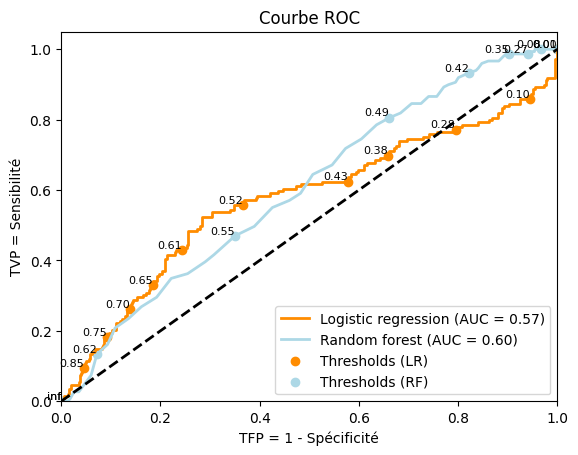

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, smx_lr[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, smx_rf[:, 1])
# Calculer l'aire sous la courbe ROC (AUC)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='lightblue', lw=2, label='Random forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Afficher les points correspondant aux seuils avec un pas de 0.1
threshold_indices_lr = [i for i, threshold in enumerate(thresholds_lr) if i % 20 == 0]
threshold_indices_rf = [i for i, threshold in enumerate(thresholds_rf) if i % 10 == 0]

plt.scatter(fpr_lr[threshold_indices_lr], tpr_lr[threshold_indices_lr], marker='o', color='darkorange', label='Thresholds (LR)')
plt.scatter(fpr_rf[threshold_indices_rf], tpr_rf[threshold_indices_rf], marker='o', color='lightblue', label='Thresholds (RF)')

# Ajouter des annotations indiquant la valeur des seuils
for i in threshold_indices_lr:
    plt.text(fpr_lr[i], tpr_lr[i], f'{thresholds_lr[i]:.2f}', fontsize=8, ha='right', va='bottom')

for i in threshold_indices_rf:
    plt.text(fpr_rf[i], tpr_rf[i], f'{thresholds_rf[i]:.2f}', fontsize=8, ha='right', va='bottom')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('TFP = 1 - Spécificité')
plt.ylabel('TVP = Sensibilité')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.savefig("fig/classi/roc.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

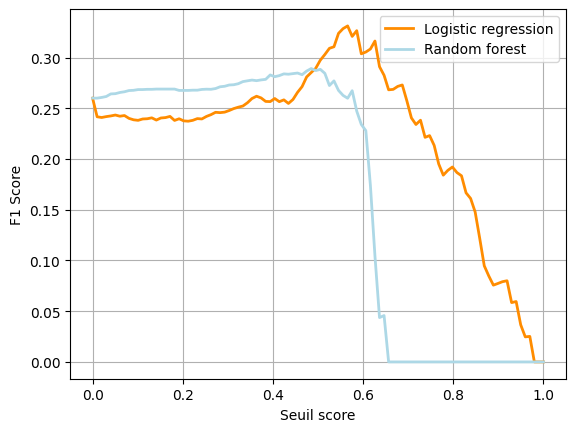

In [8]:
# Définition des seuils de classification pour lesquels on va calculer
# les f1 scores
threshold_array = np.linspace(0, 1, 100)
f1_list_lr = []
f1_list_rf = []

# Boucle pour calculer le f1 score pour chaque seuil
for threshold in threshold_array:
    # Prédiction des étiquettes pour un seuil donné
    pred_threshold_lr = (smx_lr[:, 1] > threshold).astype(int)
    pred_threshold_rf = (smx_rf[:, 1] > threshold).astype(int)
    
    # Calcul du f1 score pour un seuil donné
    f1_threshold_lr = f1_score(y_true=y_test, y_pred=pred_threshold_lr)
    f1_threshold_rf = f1_score(y_true=y_test, y_pred=pred_threshold_rf)
    
    # Ajout du f1 score à la liste
    f1_list_lr.append(f1_threshold_lr)
    f1_list_rf.append(f1_threshold_rf)

# Tracer la courbe des f1 scores en fonction des seuils
plt.plot(threshold_array, f1_list_lr, color='darkorange', lw=2,label='Logistic regression')
plt.plot(threshold_array, f1_list_rf, color='lightblue', lw=2,label='Random forest')
plt.xlabel('Seuil score')
plt.ylabel('F1 Score')
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("fig/classi/f1_score.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

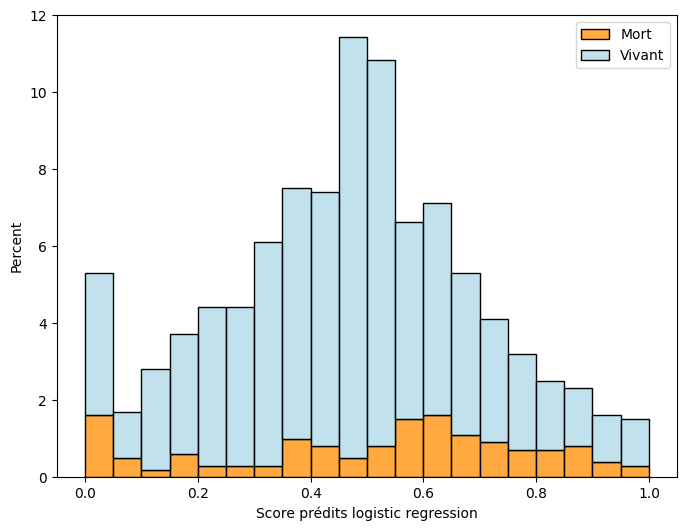

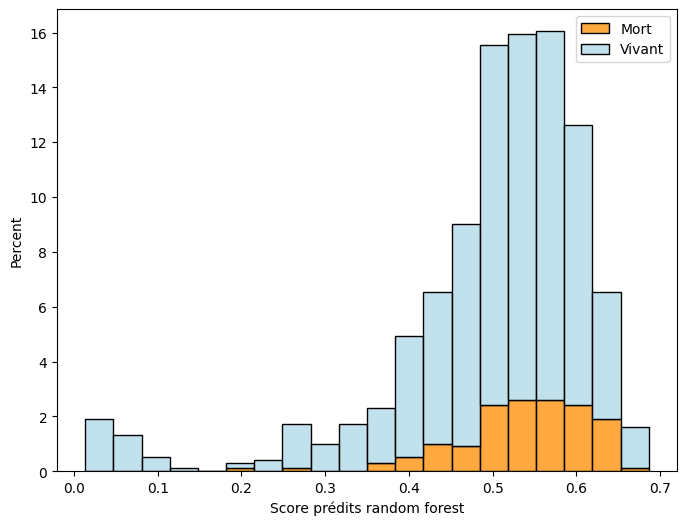

In [9]:
df = pd.DataFrame({
    'score': smx_lr[:, 1],
    'true_label': y_test
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(data=df, x='score', hue='true_label', multiple="stack", stat='percent',
    palette={1: 'darkorange', 0: 'lightblue'}, bins=20, hue_order=[0, 1])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, frameon=False,
)
ax.legend(['Mort', 'Vivant'])
plt.xlabel("Score prédits logistic regression")
plt.savefig("fig/classi/histo_score_lr.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()


df = pd.DataFrame({
    'score': smx_rf[:, 1],
    'true_label': y_test
})

plt.figure(figsize=(8, 6))
ax = sns.histplot(data=df, x='score', hue='true_label', multiple="stack", stat='percent',
    palette={1: 'darkorange', 0: 'lightblue'}, bins=20, hue_order=[0, 1])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, frameon=False,
)
ax.legend(['Mort', 'Vivant'])
plt.xlabel("Score prédits random forest")
plt.savefig("fig/classi/histo_score_rf.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# Prédiction conforme (binaire)

In [31]:
# Problem setup
n = 500 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage
q_level = np.ceil((n+1)*(1-alpha))/n

# Split the softmax scores into calibration and validation sets (save the shuffling)
smx = smx_rf
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)

# ix est un vecteur de taille 50 000 (nb d'images) qui contient n True et 50 000 - n False disposé aléatoirement
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = y_test[idx], y_test[~idx]

## Conformal p-values

In [34]:
c = 0
q = 0.6

# Calcul des scores de conformité Vi pour les données d'étalonnage
cal_scores = cal_labels - cal_smx[:, 1]
cal_scores_bis = 100*cal_labels - cal_smx[:, 1]
# Calcul des scores de conformité Vn+j pour les données de test
test_scores = c - val_smx[:, 1]
test_scores_bis = 100 - val_smx[:, 1]

def BH(calib_scores, test_scores, q = 0.1):
    ntest = len(test_scores)
    ncalib = len(calib_scores)
    pvals = np.zeros(ntest)
    
    for j in range(ntest):
        pvals[j] = (np.sum(calib_scores < test_scores[j]) + 1) / (ncalib+1)
         
    # BH(q) 
    df_test = pd.DataFrame({"id": range(ntest), "pval": pvals}).sort_values(by='pval')
    
    df_test['threshold'] = q * np.linspace(1, ntest, num=ntest) / ntest 
    idx_smaller = [j for j in range(ntest) if df_test.iloc[j,1] <= df_test.iloc[j,2]]
    
    if len(idx_smaller) == 0:
        return(np.array([]))
    else:
        idx_sel = np.array(df_test.index[range(np.max(idx_smaller)+1)])
        return(idx_sel)

# BH using residuals
BH_res= BH(cal_scores, test_scores, q)
# The FDR (FDP) is a natural measure of type-I error for binary classification
# Power = Rappel
if len(BH_res) == 0:
    BH_res_fdp = 0
    BH_res_power = 0
else:
    BH_res_fdp = np.sum(val_labels.reset_index(drop=True)[BH_res] <= c) / len(BH_res)
    BH_res_power = np.sum(val_labels.reset_index(drop=True)[BH_res] > c) / sum(val_labels > c)
        
print(BH_res_fdp,BH_res_power)

0.78125 0.4


In [ ]:
# Initialisation des p-valeurs conformes
p_values = np.zeros(len(test_scores))
p_values_bis = np.zeros(len(test_scores))
# Calcul des p-valeurs conformes pour chaque score de test
for j in range(len(test_scores)):
    count_V_less_than_Vnj = np.sum(cal_scores < test_scores[j])
    count_V_equal_to_Vnj = np.sum(cal_scores == test_scores[j])
    U_j = np.random.uniform()
    p_values[j] = (count_V_less_than_Vnj + (1 + count_V_equal_to_Vnj) * U_j) / (len(cal_scores) + 1)
    p_values_bis[j] = (count_V_less_than_Vnj + 1) / (len(cal_scores) + 1)

# Affichage des p-valeurs conformes
print("P-values conformes :", p_values, p_values_bis)

# Initialiser k* à 0
k_star = 0

# Parcourir les p-valeurs conformes dans l'ordre décroissant
for k in range(len(test_scores)):
    # Calculer la proportion de p-valeurs conformes inférieures ou égales à qk/m
    proportion = np.sum(p_values <=  q*k/ m)
    
    # Vérifier si la proportion est supérieure ou égale à k
    if proportion >= k:
        # Mettre à jour k* avec la valeur actuelle de k
        k_star = k + 1
print(k)

## Outlier Detection

The empirical coverage is: 0.7887323943661971
Taux d'erreur de type 2 : 0.8142857142857143


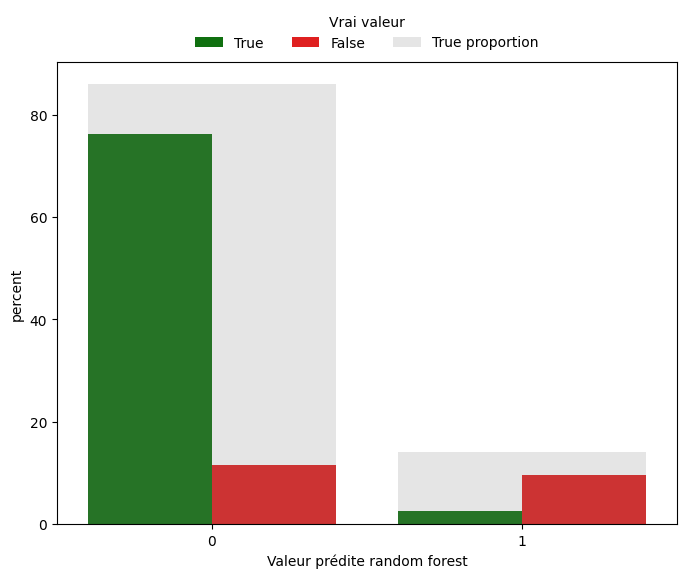

In [33]:
# 1: get conformal scores
cal_scores = cal_smx[:, 1]

# 2: get adjusted quantile
qhat = np.quantile(cal_scores, q_level, method='higher') # valeur du 9 ème décile environ

# 3: form prediction sets
prediction_sets = val_smx[:, 1] > qhat
# Pour chaque image du set de validation, on garde les labels dont le softmax dépasse le seuil (on remplace les valeurs par True/False) 

# Calculate empirical coverage
empirical_coverage = prediction_sets == val_labels
# On regarde en moyenne si le set de prédiction contient bien le vrai label
print(f"The empirical coverage is: {empirical_coverage.mean()}")

# Trouver les cas où la prédiction est négative mais la vraie classe est positive
erreur_type_2 = (prediction_sets == False) & (val_labels == 1)

# Calculer le pourcentage d'erreurs de type 2 par rapport au total des prédictions positives
erreur_type_2_rate = erreur_type_2.sum() / val_labels.sum()

print("Taux d'erreur de type 2 :", erreur_type_2_rate)


# Création du DataFrame
df = pd.DataFrame(prediction_sets, columns=['col1'])

# Création de la nouvelle colonne
df['set'] = np.where(df['col1'], 1, 0)

df['empirical_coverage'] = empirical_coverage.reset_index(drop=True)

df['val_labels'] = val_labels.reset_index(drop=True)

# Création du countplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="set", hue="empirical_coverage", palette={True: 'green', False: 'red'},
              hue_order=[True, False], ax=ax, stat='percent')

# Countplot des val_labels sur le deuxième axe y
sns.countplot(data=df, x="val_labels", alpha=0.2, stat='percent', label='True proportion', color='gray')
sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title="Vrai valeur", frameon=False,
    )

# Réglages des légendes et sauvegarde du graphique
plt.xlabel("Valeur prédite random forest")
plt.savefig("fig/classi/outlier_rf.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# LR
# The empirical coverage is: 0.7991967871485943
# Taux d'erreur de type 2 : 0.8260869565217391

# RF 
# The empirical coverage is: 0.8052208835341366
# Taux d'erreur de type 2 : 0.825

## Split conformal + small sets

The empirical coverage is: 0.8832997987927566


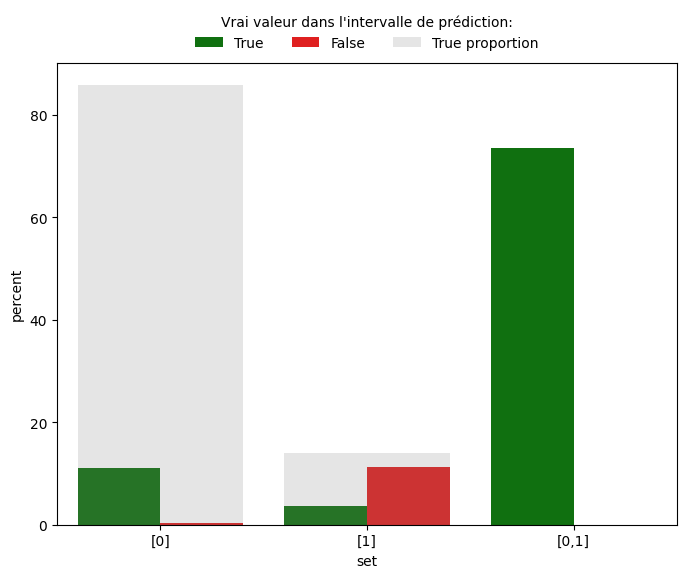

The prediction set is: ['0']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 0
The prediction set is: ['0']
The real value is: 1
The prediction set is: ['1']
The real value is: 0
The prediction set is: ['0', '1']
The real value is: 1
The prediction set is: ['0', '1']
The real value is: 0


In [32]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# Pour chacunes des images du set de calibration, score de conformité = 1-softmax associé au vrai label (liste de n éléments)
# score de conformité élevé quand softmax faible = prédiction du model mauvaise

# 2: get adjusted quantile
qhat = np.quantile(cal_scores, q_level, method='higher') # valeur du 9 ème décile environ

# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)
# Pour chaque image du set de validation, on garde les labels dont le softmax dépasse le seuil (on remplace les valeurs par True/False) 

# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels]
# On regarde en moyenne si le set de prédiction contient bien le vrai label
print(f"The empirical coverage is: {empirical_coverage.mean()}")

# Création du DataFrame
df = pd.DataFrame(prediction_sets, columns=['col1', 'col2'])

# Création de la nouvelle colonne
df['set'] = np.where(df['col1'] & df['col2'], '[0,1]',
                         np.where(df['col1'], '[0]', 
                                  np.where(df['col2'], '[1]', '[]')))

df['empirical_coverage'] = empirical_coverage

df['val_labels'] = val_labels.reset_index(drop=True)
df['val_labels'] = df['val_labels'].replace({0: '[0]', 1: '[1]'})

# Spécification de l'ordre des catégories
order = ['[0]', '[1]', '[0,1]']

# Conversion de la colonne 'set' en catégorie avec l'ordre spécifié
df['set'] = pd.Categorical(df['set'], categories=order, ordered=True)

# Création du countplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="set", hue="empirical_coverage", palette={True: 'green', False: 'red'},
              hue_order=[True, False], ax=ax, stat='percent')

# Countplot des val_labels sur le deuxième axe y
sns.countplot(data=df, x="val_labels", alpha=0.2, stat='percent', label='True proportion', color='gray')
sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title="Vrai valeur dans l'intervalle de prédiction:", frameon=False,
    )

# Réglages des légendes et sauvegarde du graphique
plt.savefig("fig/classi/split_small_sets_rf.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

for i in range(10):
    prediction_set = smx[i] > 1-qhat
    label_strings = ["0","1"]
    filtered_labels = [label for keep, label in zip(list(prediction_set), label_strings) if keep]
    print(f"The prediction set is: {filtered_labels}")
    print(f"The real value is: {y_test[i]}")

## Split conformal + meilleur RAPS (Random Adaptative Prediction Set)

In [ ]:
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.01
k_reg = 1
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (smx.shape[1]-k_reg)*[lam_reg,])[None,:]

# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:,::-1]; 
print(cal_pi.shape)
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1)
print(cal_srt.shape)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels.values[:, None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, q_level, interpolation='higher')
# Deploy
n_val = val_smx.shape[0]
val_pi = val_smx.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_smx,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)


# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(n_val),val_labels]
# On regarde en moyenne si le set de prédiction contient bien le vrai label
print(f"The empirical coverage is: {empirical_coverage.mean()}")

# Création du DataFrame
df = pd.DataFrame(prediction_sets, columns=['col1', 'col2'])

# Création de la nouvelle colonne
df['set'] = np.where(df['col1'] & df['col2'], '[0,1]',
                         np.where(df['col1'], '[0]', 
                                  np.where(df['col2'], '[1]', '[]')))

df['empirical_coverage'] = empirical_coverage

df['val_labels'] = val_labels.reset_index(drop=True)
df['val_labels'] = df['val_labels'].replace({0: '[0]', 1: '[1]'})

# Spécification de l'ordre des catégories
order = ['[0]', '[1]', '[0,1]']

# Conversion de la colonne 'set' en catégorie avec l'ordre spécifié
df['set'] = pd.Categorical(df['set'], categories=order, ordered=True)

# Création du countplot
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="set", hue="empirical_coverage", palette={True: 'green', False: 'red'},
              hue_order=[True, False], ax=ax, stat='percent')

# Countplot des val_labels sur le deuxième axe y
sns.countplot(data=df, x="val_labels", alpha=0.2, stat='percent', label='True proportion', color='gray')
sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title="Vrai valeur dans l'intervalle de prédiction:", frameon=False,
    )

# Réglages des légendes et sauvegarde du graphique
plt.savefig("fig/classi/split_raps_rf.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

for i in range(10):
    prediction_set = smx[i] > 1-qhat
    label_strings = ["0","1"]
    filtered_labels = [label for keep, label in zip(list(prediction_set), label_strings) if keep]
    print(f"The prediction set is: {filtered_labels}")
    print(f"The real value is: {y_test[i]}")

## Full conformal + small sets

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignorer les avertissements de convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def full_conformal(k):
    X = pd.concat([X_train, X_test.iloc[k:k+1]])
    y = y_train.copy() 
    n = len(y_train)
    prediction = []
    for i in range(2):
        y.loc[n] = i
        model.fit(X, y)
        smx = model.predict_proba(X)
        scores = 1-smx[np.arange(n+1), y]
        qhat = np.quantile(scores[:-1], q_level, method='higher') # valeur du 9 ème décile environ
        if scores[-1] <= qhat:
            prediction.append(str(i))
    return prediction

for i in range(5):
    prediction_set = full_conformal(i)
    print(f"The prediction set is: {prediction_set}")
    print(f"The real value is: {y_test[i]}")

# Modèles ML Durée de séjour des patients (régression)

## Random Forest
Notice that the random forests regressor **estimates the conditional mean** of $Y_i$ given $X_i=x$.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import math

# Définir les valeurs des hyperparamètres à tester

# Créer un dictionnaire de valeurs à tester pour le nombre maximal de caractéristiques utilisées à chaque division de l'arbre
param_grid = {
    'max_features': list(range(30, 121, 10))
}

# Initialisation du modèle Random Forest

# Créer une instance du modèle Random Forest avec des hyperparamètres spécifiés
model = RandomForestRegressor(criterion='squared_error', n_estimators=150, random_state = seed)

# Définir la métrique MSE comme score
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mse_scorer)

# Effectuer la recherche des meilleurs hyperparamètres en utilisant les données d'entraînement
grid_search.fit(X_train, y_train)

# Obtenir les meilleures valeurs des hyperparamètres
best_max_features = grid_search.best_params_['max_features']

# Utilisation du modèle avec les meilleurs hyperparamètres pour la prédiction sur l'ensemble de test

# Créer une nouvelle instance du modèle Random Forest avec les meilleurs hyperparamètres trouvés
model = RandomForestRegressor(criterion='squared_error', n_estimators=150, max_features=best_max_features, 
    random_state = seed, oob_score=True)

# Entraîner le modèle avec les meilleurs hyperparamètres sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test en utilisant le modèle entraîné
y_pred = model.predict(X_test)

# Évaluation des performances du modèle
oob_score = model.oob_score_
print("Out-of-Bag Score: %.2f" % (oob_score))

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % (mse))

r2 = r2_score(y_test, y_pred)
print("R-squared: %.2f" % (r2))

# OOB : 0.22
# MSE : 70702.01
# R^2 : 0.26
# 20 min

### Split conformal

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import AbsErrorErrFunc

# define a conformal prediction object 
nc = RegressorNc(model, AbsErrorErrFunc())

# build a regualr split conformal prediction object 
icp = IcpRegressor(nc)

# fit the conditional mean regression to the proper training data
icp.fit(X_train, y_train)

# compute the absolute residual error on calibration data
icp.calibrate(X_test[idx], y_test[idx])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(X_test[~idx].values, significance=alpha)
y_lower_split = np.maximum(predictions[:, 0], 0)
y_upper_split = predictions[:,1]

# compute the conditional mean estimation
pred_rf = model.predict(X_test[~idx])

In [ ]:
# compute and display the average coverage
in_the_range_split = (y_test[~idx] >= y_lower_split) & (y_test[~idx]<= y_upper_split)
print("Percentage in the range (expecting %.2f%%): %.2f%%" % (100*(1-alpha), np.sum(in_the_range_split) / len(y_test[~idx]) * 100))

# compute length of the interval per each test point
length_split = y_upper_split - y_lower_split
print("Average length:", round(np.mean(length_split)))
print("Standard deviation of length:", round(np.std(length_split)))

plot_func(y=y_test[~idx],y_u=y_upper_split,y_l=y_lower_split,pred=pred_rf,shade_color='tomato',
          method_name="Split:",title="Random Forests (mean regression)",
          filename="fig/regres/lineplot_split.png",save_figures=True)

plot_hist(length = length_split, in_the_range = in_the_range_split, x_name="Length Split", dec_x_quant= [0,0,0],
      filename="fig/regres/histo_length_split.png", save_figures=True)

# Percentage in the range (expecting 90.0%): 92.76%
# Average length: 593
# Standard deviation of length: 102

In [ ]:
with open('data/traite/pred_rf', 'wb') as f1:
    pickle.dump(pred_rf, f1)
with open('data/traite/y_upper_split', 'wb') as f1:
    pickle.dump(y_upper_split, f1)
with open('data/traite/y_lower_split', 'wb') as f1:
    pickle.dump(y_lower_split, f1)

### CV+ for K-fold cross-validation (Jacknife + if K=len(X_train_K))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

q_level = np.ceil((n+1)*(1-alpha))/n

X_train_K = np.concatenate((X_train, X_test[idx]), axis=0)
y_train_K = np.concatenate((y_train, y_test[idx]), axis=0)

# Initialisez l'objet KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Initialisez une liste pour stocker les index des échantillons d'entraînement
residus = np.zeros(len(X_train_K))
pred = np.zeros((len(X_train_K),len(X_test[~idx])))

# Parcourez les splits et stockez les index des échantillons d'entraînement
for train_indices, test_indices in kf.split(X_train_K):
    model.fit(X_train_K[train_indices], y_train_K[train_indices])
    residus[test_indices] = abs(y_train_K[test_indices]-model.predict(X_train_K[test_indices]))
    pred[test_indices] = np.repeat(model.predict(X_test[~idx]).reshape(1, -1), len(test_indices), axis=0)

# display the results

y_upper_cvp = np.quantile(pred+residus.reshape(-1, 1), q_level, method='higher', axis=0)
y_lower_cvp = np.maximum(- np.quantile(-pred+residus.reshape(-1, 1), q_level, method='higher', axis=0), 0)

# Entraîner le modèle avec les meilleurs hyperparamètres sur les données d'entraînement
model.fit(X_train, y_train)
pred_rf = model.predict(X_test[~idx])

# 4 min

In [ ]:
# compute and display the average coverage
in_the_range_cvp = (y_test[~idx] >= y_lower_cvp) & (y_test[~idx]<= y_upper_cvp)
print("Percentage in the range (expecting %.2f%%): %.2f%%" % (100*(1-alpha), np.sum(in_the_range_cvp) / len(y_test[~idx]) * 100))

# compute length of the interval per each test point
length_cvp = y_upper_cvp - y_lower_cvp
print("Average length:", round(np.mean(length_cvp)))
print("Standard deviation of length:", round(np.std(length_cvp)))

plot_func(y=y_test[~idx],y_u=y_upper_cvp,y_l=y_lower_cvp,pred=pred_rf,shade_color='gray',
          method_name="CV+ K folder:",title="Random Forests (mean regression)",
          filename="fig/regres/lineplot_cvp.png",save_figures=True)

plot_hist(length = length_cvp, in_the_range = in_the_range_cvp, x_name="Length CV+ K folder", dec_x_quant= [-20,0,0],
        filename="fig/regres/histo_length_cvp.png", save_figures=True)

# Percentage in the range (expecting 90.0%): 92.96%
# Average length: 601
# Standard deviation of length: 104

In [ ]:
with open('data/traite/pred_rf', 'wb') as f1:
    pickle.dump(pred_rf, f1)
with open('data/traite/y_upper_cvp', 'wb') as f1:
    pickle.dump(y_upper_cvp, f1)
with open('data/traite/y_lower_cvp', 'wb') as f1:
    pickle.dump(y_lower_cvp, f1)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

# Définir les constantes
n_splits_range = range(2, 16)
length_cvp_means = []
length_cvp_med = []

q_level = np.ceil((n+1)*(1-alpha))/n

X_train_K = np.concatenate((X_train, X_test[idx]), axis=0)
y_train_K = np.concatenate((y_train, y_test[idx]), axis=0)

# Initialisez une liste pour stocker les index des échantillons d'entraînement
residus = np.zeros(len(X_train_K))
pred = np.zeros((len(X_train_K),len(X_test[~idx])))

# Boucle sur le nombre de splits
for n_splits in n_splits_range:
    # Initialisez l'objet KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Parcourez les splits et exécutez le processus de validation croisée
    for train_indices, test_indices in kf.split(X_train_K):
        model.fit(X_train_K[train_indices], y_train_K[train_indices])
        residus[test_indices] = abs(y_train_K[test_indices] - model.predict(X_train_K[test_indices]))
        pred[test_indices] = np.repeat(model.predict(X_test[~idx]).reshape(1, -1), len(test_indices), axis=0)

    # Calcul de length_cvp pour chaque test point
    y_upper = np.quantile(pred + residus.reshape(-1, 1), q_level, method='higher', axis=0)
    y_lower = np.maximum(- np.quantile(-pred + residus.reshape(-1, 1), q_level, method='higher', axis=0), 0)
    length_cvp = y_upper - y_lower
    length_cvp_means.append(np.mean(length_cvp))
    length_cvp_med.append(np.quantile(length_cvp, 0.5))
    print(n_splits)
    print("Random Forests: Average length:", np.mean(length_cvp), np.quantile(length_cvp, 0.5))

# Tracer l'évolution de length_cvp en fonction du nombre de splits
plt.plot(n_splits_range, length_cvp_means, color='lightblue', label='Moyenne')
plt.plot(n_splits_range, length_cvp_med, color ='darkorange', label='Médiane')
plt.xlabel('Nombre de splits')
plt.ylabel('Length')
plt.title('Évolution de length en fonction du nombre de splits')
plt.legend(loc="upper right")
plt.savefig("fig/regres/lineplot_k_folder.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# 147 min pour K jusqu'à 15

## CQR Random Forests

Given any quantile regression algorithm $\mathcal{A}$ (the function `QuantileForestRegressorAdapter` in the code below), we then fit two conditional quantile functions $\hat{q}_{\alpha_{lo}}$ and $\hat{q}_{\alpha_{hi}}$ on the proper training set: $$ \{ \hat{q}_{\alpha_{lo}}, \hat{q}_{\alpha_{hi}} \} \leftarrow \mathcal{A}(\left\lbrace (X_i, Y_i): i \in I_1 \right\rbrace). $$
This is done by calling the function `icp.fit`.

In the essential next step, the function `icp.calibrate` computes conformity scores (using `QuantileRegErrFunc`) that quantify the error made by the plug-in prediction interval $ \hat{C}(x) = [\hat{q}_{\alpha_{lo}}(x), \ \hat{q}_{\alpha_{hi}}(x)]  $. The scores are evaluated on the calibration set as
$$
	E_i := \max\{\hat{q}_{\alpha_{lo}}(X_i) - Y_i, Y_i - \hat{q}_{\alpha_{hi}}(X_i)\},
$$
for each $i \in I_2$. The conformity score accounts for both undercoverage and overcoverage.

Finally, given new input data $X_{n+1}$, we construct the prediction interval for $Y_{n+1}$ as
$$
C(X_{n+1}) = \left[ \hat{q}_{\alpha_{lo}}(X_{n+1}) - Q_{1-\alpha}(E, I_2) , \ \hat{q}_{\alpha_{hi}}(X_{n+1}) + Q_{1-\alpha}(E, I_2) \right],
$$
where 
$$
Q_{1-\alpha}(E, I_2) :=  (1-\alpha)(1+1/|I_2|)\text{-th empirical quantile of} \left\{E_i : i \in I_2\right\}
$$
conformalizes the plug-in prediction interval. This is done by calling the function `icp.predict`.

In [ ]:
# pip3 install setuptools numpy scipy scikit-learn cython
# pip3 install scikit-garden python version 3.7 (code à modifier)
# OU pip3 install quantile_forest

from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc, QuantileRegAsymmetricErrFunc

# the number of trees in the forest
n_estimators = 150

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = X_train.shape[1]

# target quantile levels
# desired quanitile levels
quantiles = [5, 95]

# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 1 #0.80

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = seed

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10

# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

# define the QRF model
model = helper.QuantileForestRegressorAdapter(model=None,fit_params=None,
                                                quantiles=quantiles,
                                                params=params_qforest)


model.fit(X_train, y_train)

# 61 min

### Split

In [ ]:
# pip3 install setuptools numpy scipy scikit-learn cython
# pip3 install scikit-garden python version 3.7 (code à modifier)
# OU pip3 install quantile_forest

from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc, QuantileRegAsymmetricErrFunc

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(model, QuantileRegErrFunc()) # ou QuantileRegAsymmetricErrFunc / QuantileRegErrFunc

# build the split CQR object
icp = IcpRegressor(nc)

# compute the absolute errors on calibration data
icp.calibrate(X_test[idx], y_test[idx])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(X_test[~idx].values, significance=alpha)
y_lower_cqr = np.maximum(predictions[:, 0], 0)
y_upper_cqr = predictions[:,1]

# compute the low and high conditional quantile estimation
pred_qr = model.predict(X_test[~idx].values)
y_lower_qr = np.maximum(pred_qr[:, 0], 0)
y_upper_qr = pred_qr[:,1]

# 62 min

In [ ]:
# compute and display the average coverage
in_the_range_qr = (y_test[~idx] >= y_lower_qr) & (y_test[~idx]<= y_upper_qr)
print("Percentage in the range (expecting %.2f%%): %.2f%%" % (100*(1-alpha), np.sum(in_the_range_qr) / len(y_test[~idx]) * 100))

# compute length of the conformal interval per each test point
length_qr = y_upper_qr - y_lower_qr
print("Average length:", round(np.mean(length_qr)))
print("Standard deviation of length:", round(np.std(length_qr)))

# compute and display the average coverage
in_the_range_cqr = (y_test[~idx] >= y_lower_cqr) & (y_test[~idx]<= y_upper_cqr)
print("Percentage in the range (expecting %.2f%%): %.2f%%" % (100*(1-alpha), np.sum(in_the_range_cqr) / len(y_test[~idx]) * 100))

# compute length of the conformal interval per each test point
length_cqr = y_upper_cqr - y_lower_cqr
print("Average length:", round(np.mean(length_cqr)))
print("Standard deviation of length:", round(np.std(length_cqr)))

plot_func(y=y_test[~idx],y_u=y_upper_cqr,y_l=y_lower_cqr,pred=pred_qr,shade_color='lightblue',
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="fig/regres/lineplot_cqr.png",save_figures=True)

plot_hist(length = length_cqr, in_the_range = in_the_range_cqr, x_name="Length CQR", dec_x_quant= [-200,90,70],
        filename="fig/regres/histo_length_cqr.png", save_figures=True)

plot_hist(length = length_qr, in_the_range = in_the_range_qr, x_name="Length QR", dec_x_quant= [-200,90,70],
        filename="fig/regres/histo_length_cqr.png", save_figures=True)

# Percentage in the range (expecting 90.0%): 95.77%
# Average length: 665
# Standard deviation of length: 579

# Percentage in the range (expecting 90.0%): 93.76%
# Average length: 648
# Standard deviation of length: 579

In [ ]:
with open('data/traite/pred_qr', 'wb') as f1:
    pickle.dump(pred_qr, f1)
with open('data/traite/y_upper_cqr', 'wb') as f1:
    pickle.dump(y_upper_cqr, f1)
with open('data/traite/y_lower_cqr', 'wb') as f1:
    pickle.dump(y_lower_cqr, f1)

## Best (approximativement symmétrique)

In [ ]:
y_lower = y_lower_split.copy()
y_upper = y_upper_split.copy()

for i in range(len(y_test[~idx])):
    if pred_rf[i] < y_test[~idx].iloc[i]:
        y_lower[i] = max(pred_rf[i] - y_test[~idx].iloc[i]/2,0)
        y_upper[i] = y_test[~idx].iloc[i]
    else:
        y_lower[i] = max(y_test[~idx].iloc[i],0)
        y_upper[i] = pred_rf[i] + y_test[~idx].iloc[i]/2

# compute and display the average coverage
in_the_range = (y_test[~idx] >= y_lower) & (y_test[~idx]<= y_upper)
print("Percentage in the range (expecting %.2f%%): %.2f%%" % (100*(1-alpha), np.sum(in_the_range) / len(y_test[~idx]) * 100))

# compute length of the interval per each test point
length = y_upper - y_lower
print("Average length:", round(np.mean(length)))
print("Median length:", round(np.median(length)))
print("Standard deviation of length:", round(np.std(length)))

plot_func(y=y_test[~idx],y_u=y_upper,y_l=y_lower,pred=pred_rf,shade_color='green',
          method_name="Best:",title="Random Forests (mean regression)",
          filename="fig/regres/lineplot_best.png",save_figures=True)
          
plot_hist(length = length, in_the_range = in_the_range, x_name="Ideal length", draw_quant=False,
        filename="fig/regres/histo_length_best.png", save_figures=True)

# Percentage in the range (expecting 90.0%): 100.0
# Average length: 255
# Median length: 169
# Standard deviation of length: 270

# Comparaison des méthodes (régression)

## Comparaison de la taille des sets via lineplot

In [ ]:
fig = plt.figure()
plt.plot(np.arange(1, len(length[:100]) + 1), length[:100], color='green', lw=1.5, alpha=0.4, label='Best')
plt.plot(np.arange(1, len(length_split[:100]) + 1), length_split[:100], color='tomato', lw=1.5, alpha=0.8, label='Split')
plt.plot(np.arange(1, len(length_cvp[:100]) + 1), length_cvp[:100], color='gray', lw=1.5, alpha=0.8, label='CV+ K folder')
plt.plot(np.arange(1, len(length_cqr[:100]) + 1), length_cqr[:100], color='lightblue', lw=1.5, label='CQR')

plt.xlabel('$X$')
plt.ylabel('Length')
plt.legend(loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.1))
plt.savefig("fig/regres/lineplot_length.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

## Comparaison de la taille des sets via violinplot

In [ ]:
df_split = pd.DataFrame({
        'length': length_split,
        'in_the_range': in_the_range_split
})

df_cvp = pd.DataFrame({
        'length': length_cvp,
        'in_the_range': in_the_range_cvp
})

df_cqr = pd.DataFrame({
        'length': length_cqr,
        'in_the_range': in_the_range_cqr
})

df_best = pd.DataFrame({
        'length': length,
        'in_the_range': in_the_range
})


# Ajout de la colonne "méthode"
df_split['méthode'] = 'Split'
df_cvp['méthode'] = 'CV+ K folder'
df_cqr['méthode'] = 'CQR'
df_best['méthode'] = 'Best'

# Concaténation des dataframes
df_concat = pd.concat([df_split, df_cvp, df_cqr, df_best], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.violinplot(data=df_concat, x="méthode", y='length', hue='in_the_range', alpha=0.8, palette={True: 'green', False: 'red'},
    split=True, gap=0.05, inner="quart", hue_order=[True, False])
plt.ylim(0,df_concat['length'].max()/2)
plt.xlabel('')
plt.ylabel('Length')
plt.legend(loc='upper left', title="Vrai valeur dans l'intervalle de prédiction:")
plt.savefig("fig/regres/violin_length_zoom.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()